# Exercice Exchange Rates

## Importation des Packages

In [3]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
import seaborn as sns
import statsmodels.api as sm
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
import itertools
%matplotlib inline
from math import *
from arch import arch_model

## Décomposition de la démarche :
    
### 1 - Importation 
### 2 - Mise en forme du DataFrame
### 3 - Decritpion et Visualisation de la série

### 4 - Décompostition de la série et choix de l'historique

### 5 - Création du modèle
### 6 - Prédiction 


# 1- Importation des données

In [96]:
#importation sous forme df

df = pd.read_json('jpn.json') 
df.head()

,base,rates,end_at,start_at
1999-01-04,EUR,{'JPY': 133.73},2019-03-31,1999-01-01
1999-01-05,EUR,{'JPY': 130.96},2019-03-31,1999-01-01
1999-01-06,EUR,{'JPY': 131.42},2019-03-31,1999-01-01
1999-01-07,EUR,{'JPY': 129.43},2019-03-31,1999-01-01
1999-01-08,EUR,{'JPY': 130.09},2019-03-31,1999-01-01


Le fichier  bien été importé mais il n'est pa exploitable comme tel, je vais donc le mettre en forme.

# 2- Mise en forme du Dataframe

In [54]:
# Extraction de la date (auparavant dans l'index)

df = df.reset_index() 
df.head()


,index,base,rates,end_at,start_at
0,1999-01-04,EUR,{'JPY': 133.73},2019-03-31,1999-01-01
1,1999-01-05,EUR,{'JPY': 130.96},2019-03-31,1999-01-01
2,1999-01-06,EUR,{'JPY': 131.42},2019-03-31,1999-01-01
3,1999-01-07,EUR,{'JPY': 129.43},2019-03-31,1999-01-01
4,1999-01-08,EUR,{'JPY': 130.09},2019-03-31,1999-01-01


In [55]:
# convertit la colonne date (qui servait d'index) en vraie colonne du df

df.rename(columns={'index': 'date'}, inplace=True) # on la reomame (elle s'appellait index par def) en 'date'
df = df.drop(['base','end_at', 'start_at'], axis=1) # on supprime les colonnes qui ne nous intéressent pas
df.head()

,date,rates
0,1999-01-04,{'JPY': 133.73}
1,1999-01-05,{'JPY': 130.96}
2,1999-01-06,{'JPY': 131.42}
3,1999-01-07,{'JPY': 129.43}
4,1999-01-08,{'JPY': 130.09}


Il ne reste plus qu'a mettre en forme la variable rates.

In [56]:
#Extraction du taux de change

df['rates'] = df['rates'].astype(str) # Passage en type string pour utiliser extract
df['rates'] = df['rates'].str.replace('}','0')# Remplacement des '}' par des 0 pour avoir les valeurs à une et deux décimales
df['rates'] = df['rates']+'0'
df['rates_num'] = df['rates'].str.extract('(\d.....)', expand=True) # Extraction du taux de change


df.head(20)

,date,rates,rates_num
0,1999-01-04,{'JPY': 133.7300,133.73
1,1999-01-05,{'JPY': 130.9600,130.96
2,1999-01-06,{'JPY': 131.4200,131.42
3,1999-01-07,{'JPY': 129.4300,129.43
4,1999-01-08,{'JPY': 130.0900,130.09
5,1999-01-11,{'JPY': 126.3300,126.33
6,1999-01-12,{'JPY': 129.6300,129.63
7,1999-01-13,{'JPY': 131.8900,131.89
8,1999-01-14,{'JPY': 132.7400,132.74
9,1999-01-15,{'JPY': 131.7400,131.74


In [57]:
# Gestion format 

df['rates_num'] =df['rates_num'].astype(float) # Retour à une valeur numérique pour le taux 
df = df.drop(['rates'],axis=1)# Suppression de la colonne rates

In [58]:
# Finalisation de la mise en forme

df.columns = ['date', 'rates'] # rennomage de colonnes
df.sort_values(by=['date'], ascending=True)
df.head()

,date,rates
0,1999-01-04,133.73
1,1999-01-05,130.96
2,1999-01-06,131.42
3,1999-01-07,129.43
4,1999-01-08,130.09


In [59]:
#Verification de présence de NaN après traitement

df.isnull().sum()

date     0
rates    0
dtype: int64

Le dataframe ne comporte pas de 'NaN', les données ont bien été traitées. 

# 3 - Description et visualisation des données

In [60]:
print('Taux minimum : ',df['rates'].min())
print('Taux Maximum : ',df['rates'].max())

print('Date début : ',df['date'].min())
print('Date fin : ',df['date'].max())

Taux minimum :  89.3
Taux Maximum :  169.75
Date début :  1999-01-04 00:00:00
Date fin :  2019-03-29 00:00:00


In [61]:
df.describe()

,rates
count,5183.000000
mean,127.520475
std,16.529495
min,89.300000
25%,115.120000
50%,129.010000
75%,136.330000
max,169.750000


On comptabilise 5183 lignes, ce qui correspond à 5183 jours. Or depuis 1999, il s'est écoulé un plus grand nombre de jours.
<br> 
Cela s'explique par le fait que nous n'avons pas d'information sur le week-end, les marchées sont fermés.

On considerera alors que lundi est la suite de vendredi sans interruption.

Le taux de change fluctue entre 89.3 et 169.75, on verra mieux cela sur un bloxplot.

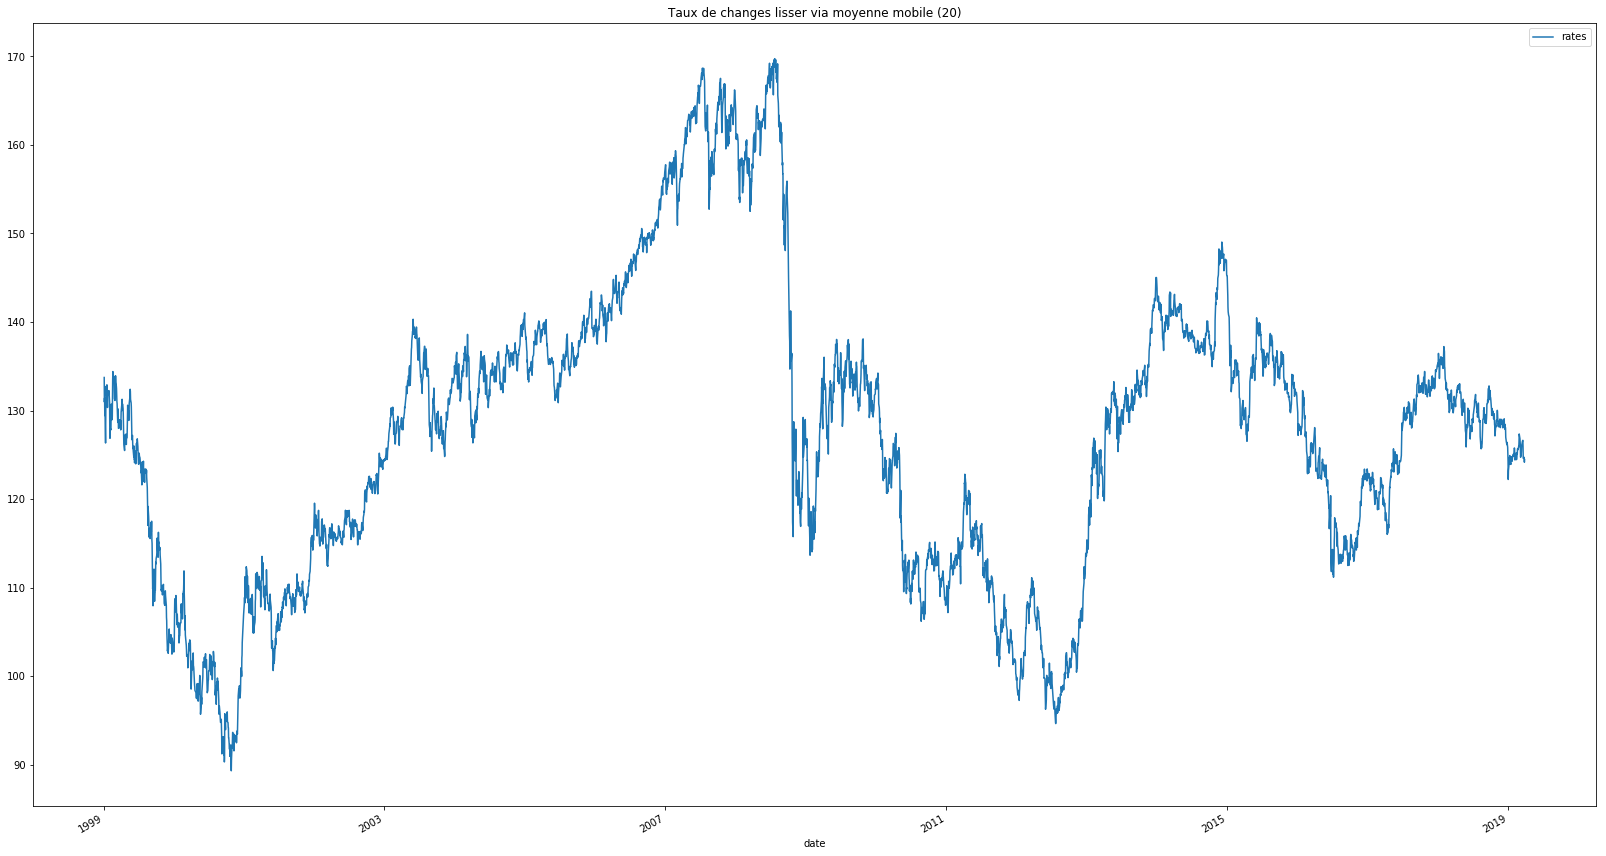

In [62]:
# Visualisation de la courbe moyenne mobile

df.plot(x = "date",y = 'rates', title = "Taux de changes lisser via moyenne mobile (20)")
rcParams['figure.figsize'] = 28, 16
plt.show()


La serie est très chaotique, chute à deux ou trios reprises pour atteindre des taux inferieur ou avoisinnant 100. <br>Ceci peut s'expliquer par des crises economiques ou recessions économiques (2000,2008,2012).
Elle atteind aussi un pic avant la crise de 2008.

In [63]:
# Calcul certaines stats descriptives

df["MA_20"]= df.rates.rolling(20).mean() # Moyenne mobile 
df["VAR_20"] = df.rates.rolling(20).var() # Variance

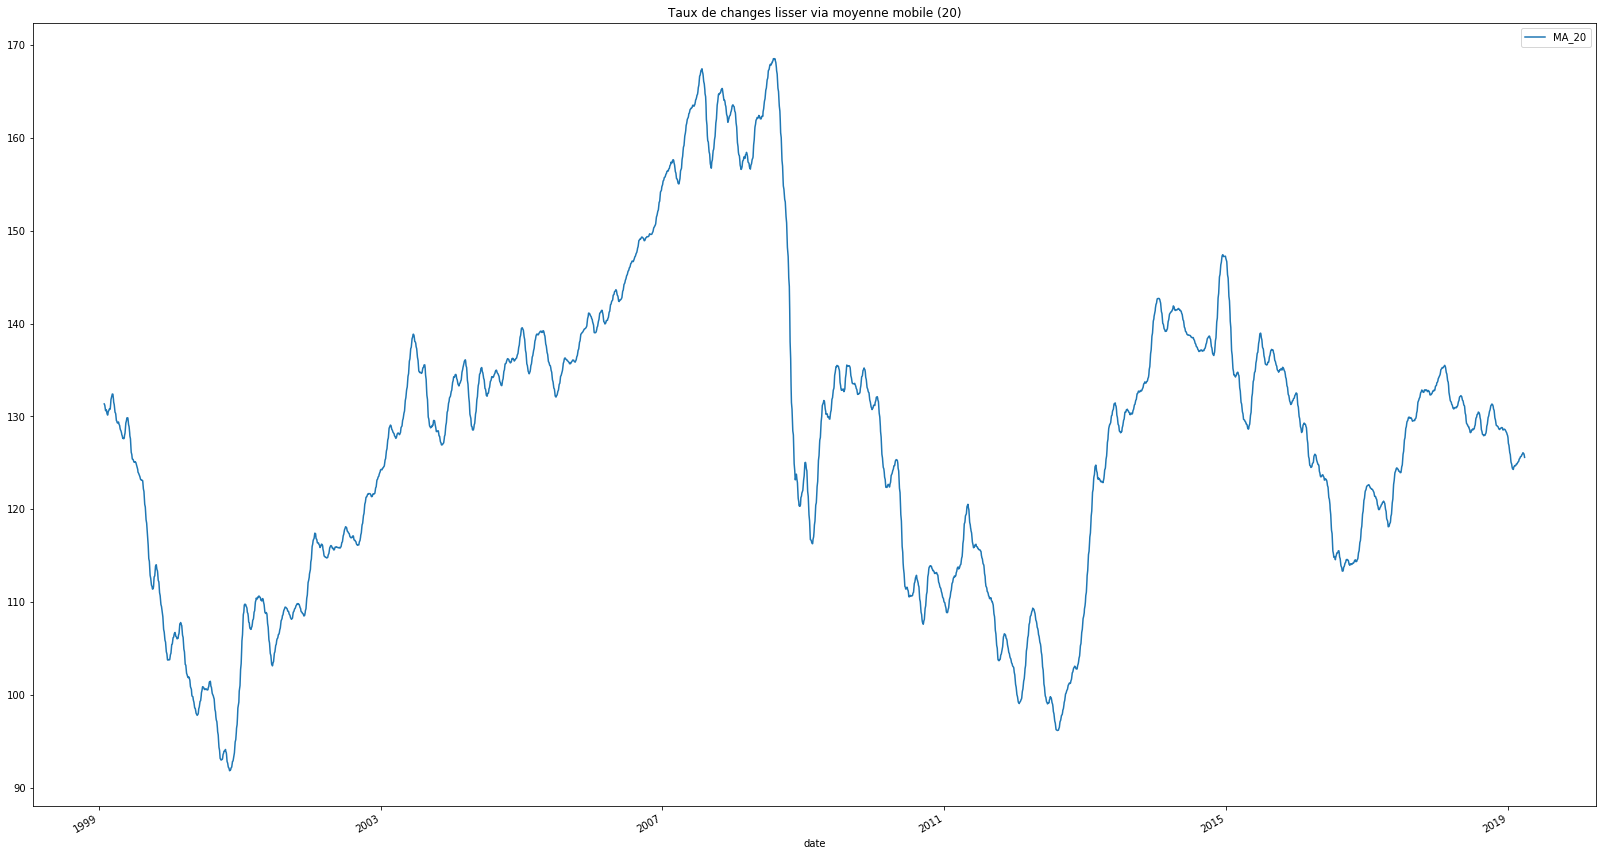

In [64]:
# Visualisation de la courbe moyenne mobile

df.plot(x = "date",y = 'MA_20', title = "Taux de changes lisser via moyenne mobile (20)")
rcParams['figure.figsize'] = 28, 16
plt.show()


Les moyennes mobiles permettent de lisser la série, elles utilisent 20 données pour être calculée ce qui correspond environ au nombre de données que l'on possède sur un mois.

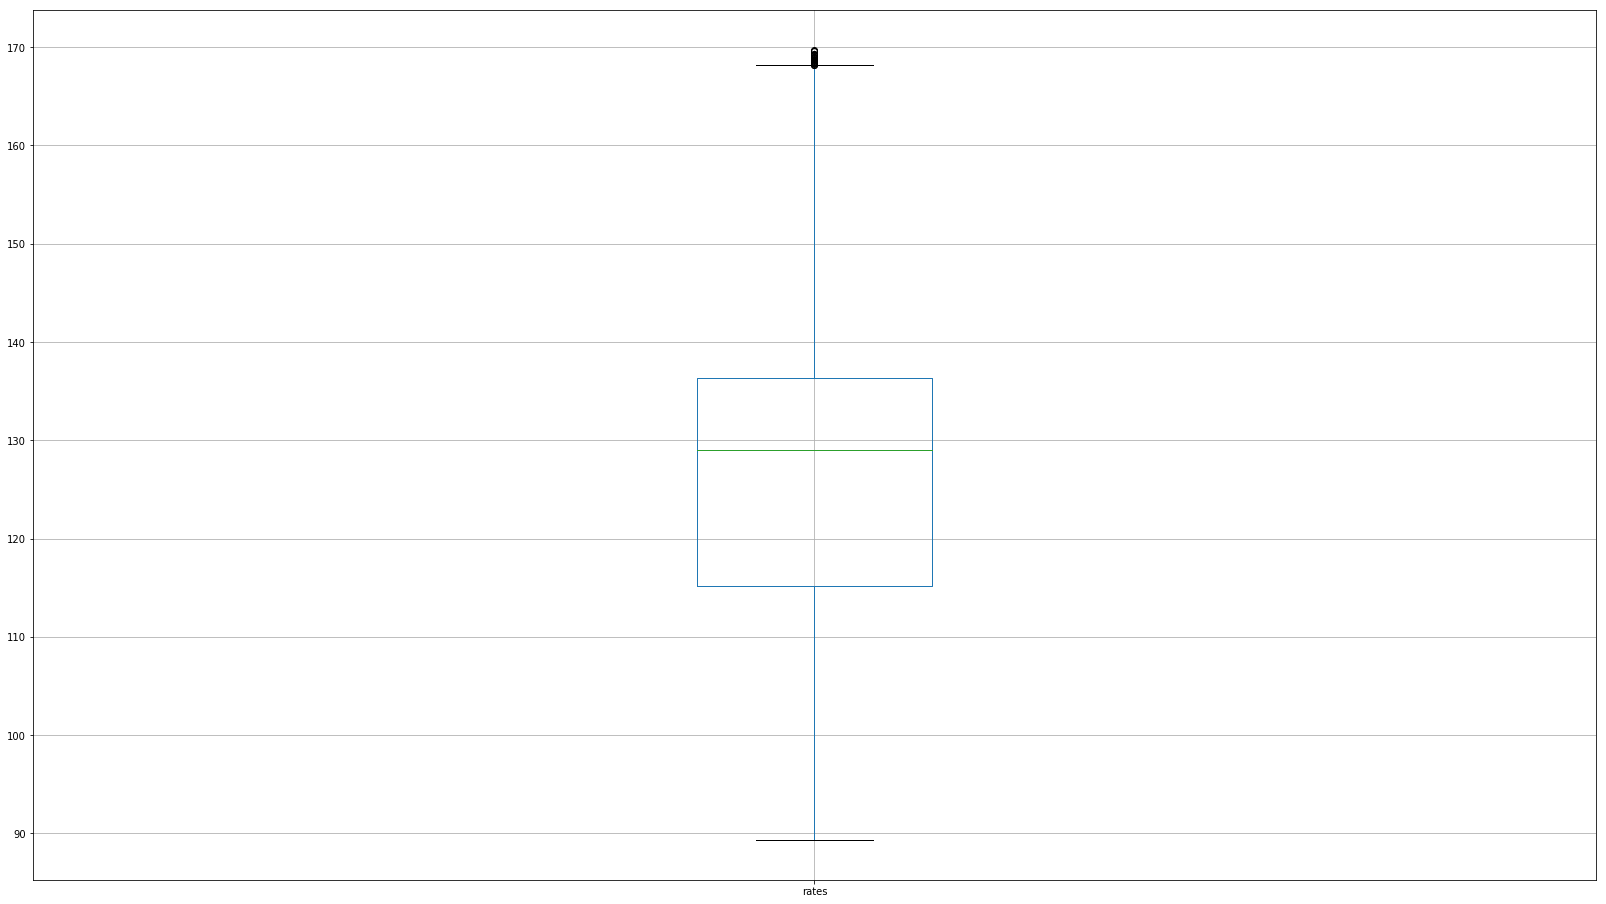

In [65]:
boxplot = df.boxplot(column=['rates'])


Du fait de ces fortes variations on peut trouver des valeurs "aberrantes" presentées par ce boxplot.

La médiane se trouve  environ 130, avec le q1 = 115 et le q3 = 136

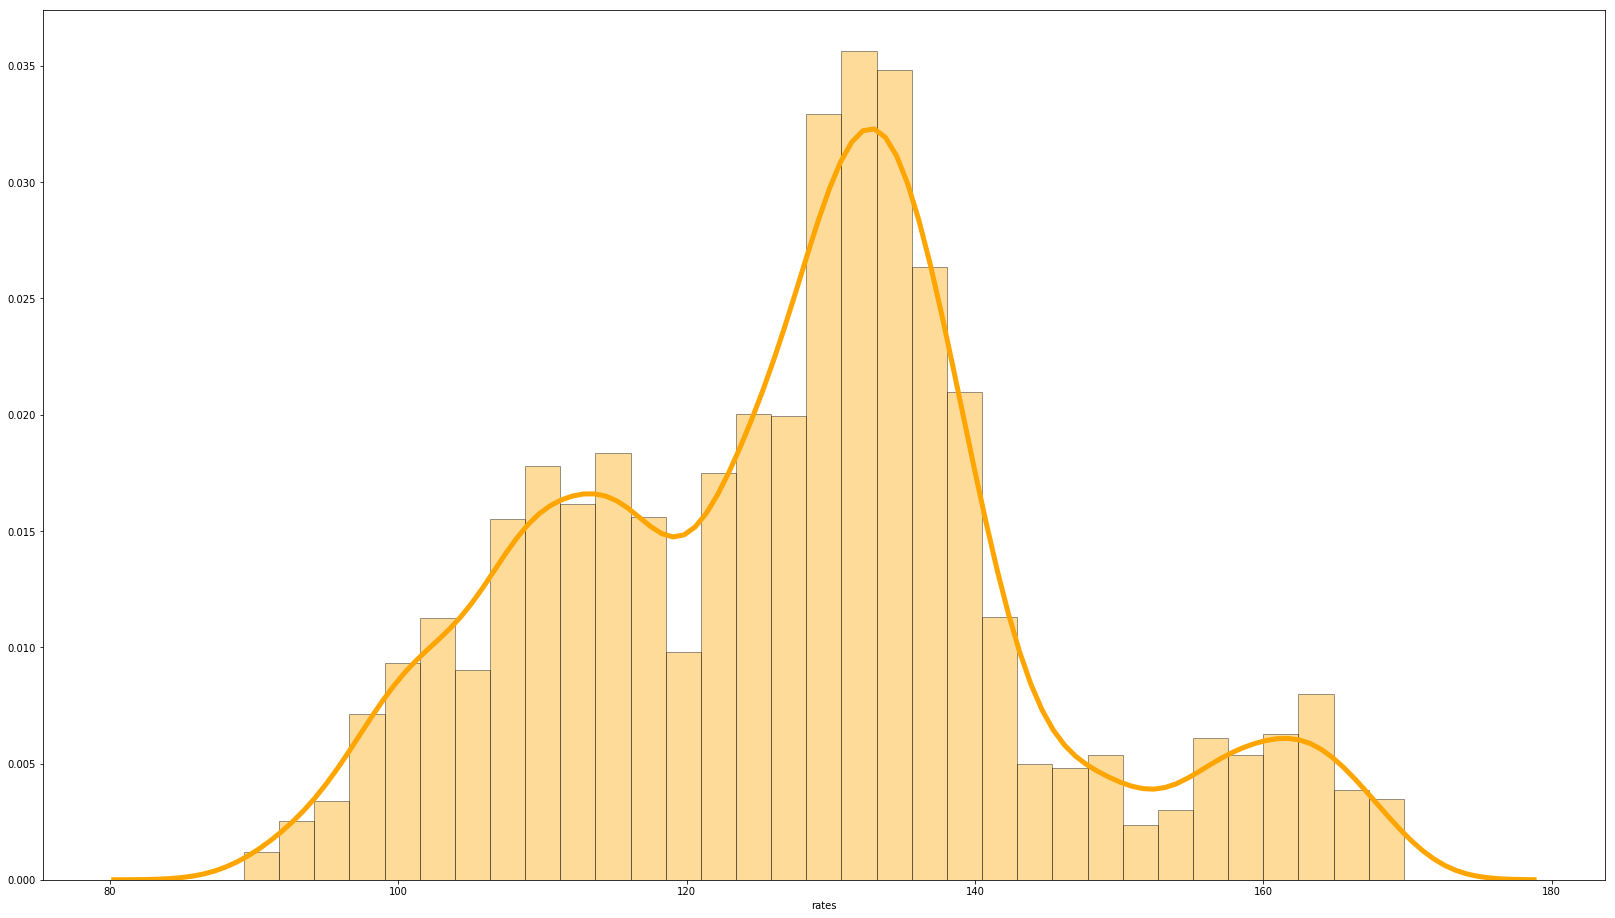

In [66]:
# Histograme de la série

warnings.filterwarnings("ignore") # supression des warnigs
sns.distplot(df['rates'], hist=True, kde=True, color = 'orange', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 5})

Les valeurs semblent distribuées autour de 120. Mais la distribution ne s'apparante pas à une loi de Gauss, en effet on remarque un pic sur les valeurs extrèmes autour de 160. 
Dans l'ensemble la courbe est plus douce au début (avec un pallier à 110) et redescend plus rapidement.

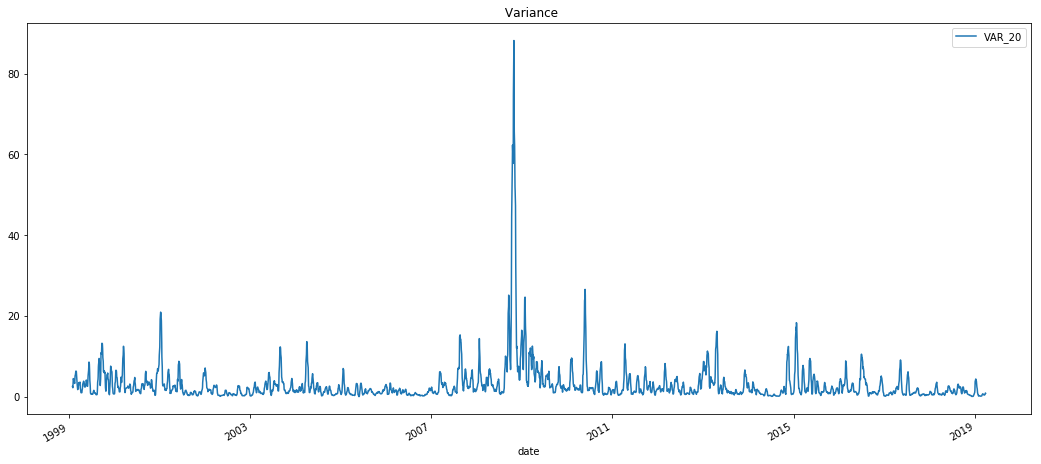

In [67]:
# PLot du Skew et de la variance 

df.plot(x = "date",y = 'VAR_20', figsize=(18,8), title = " Variance")


On voit que la variance fluctue fortement, notamment suite à la chute de 2008. <br>On retrouve aussi divers pic à différents moments.

In [68]:
# Suppréssion des stats descriptives dans le df

df = df.drop(['MA_20','VAR_20'], axis = 1)


# 4 - Décompostition de la série et choix de l'historique

### Décomposition de la serie (Tendance, Saisonalité, Bruit) depuis 1999

In [69]:
df.index= pd.DatetimeIndex(freq='w',start='1999-01-04',periods=len(df))

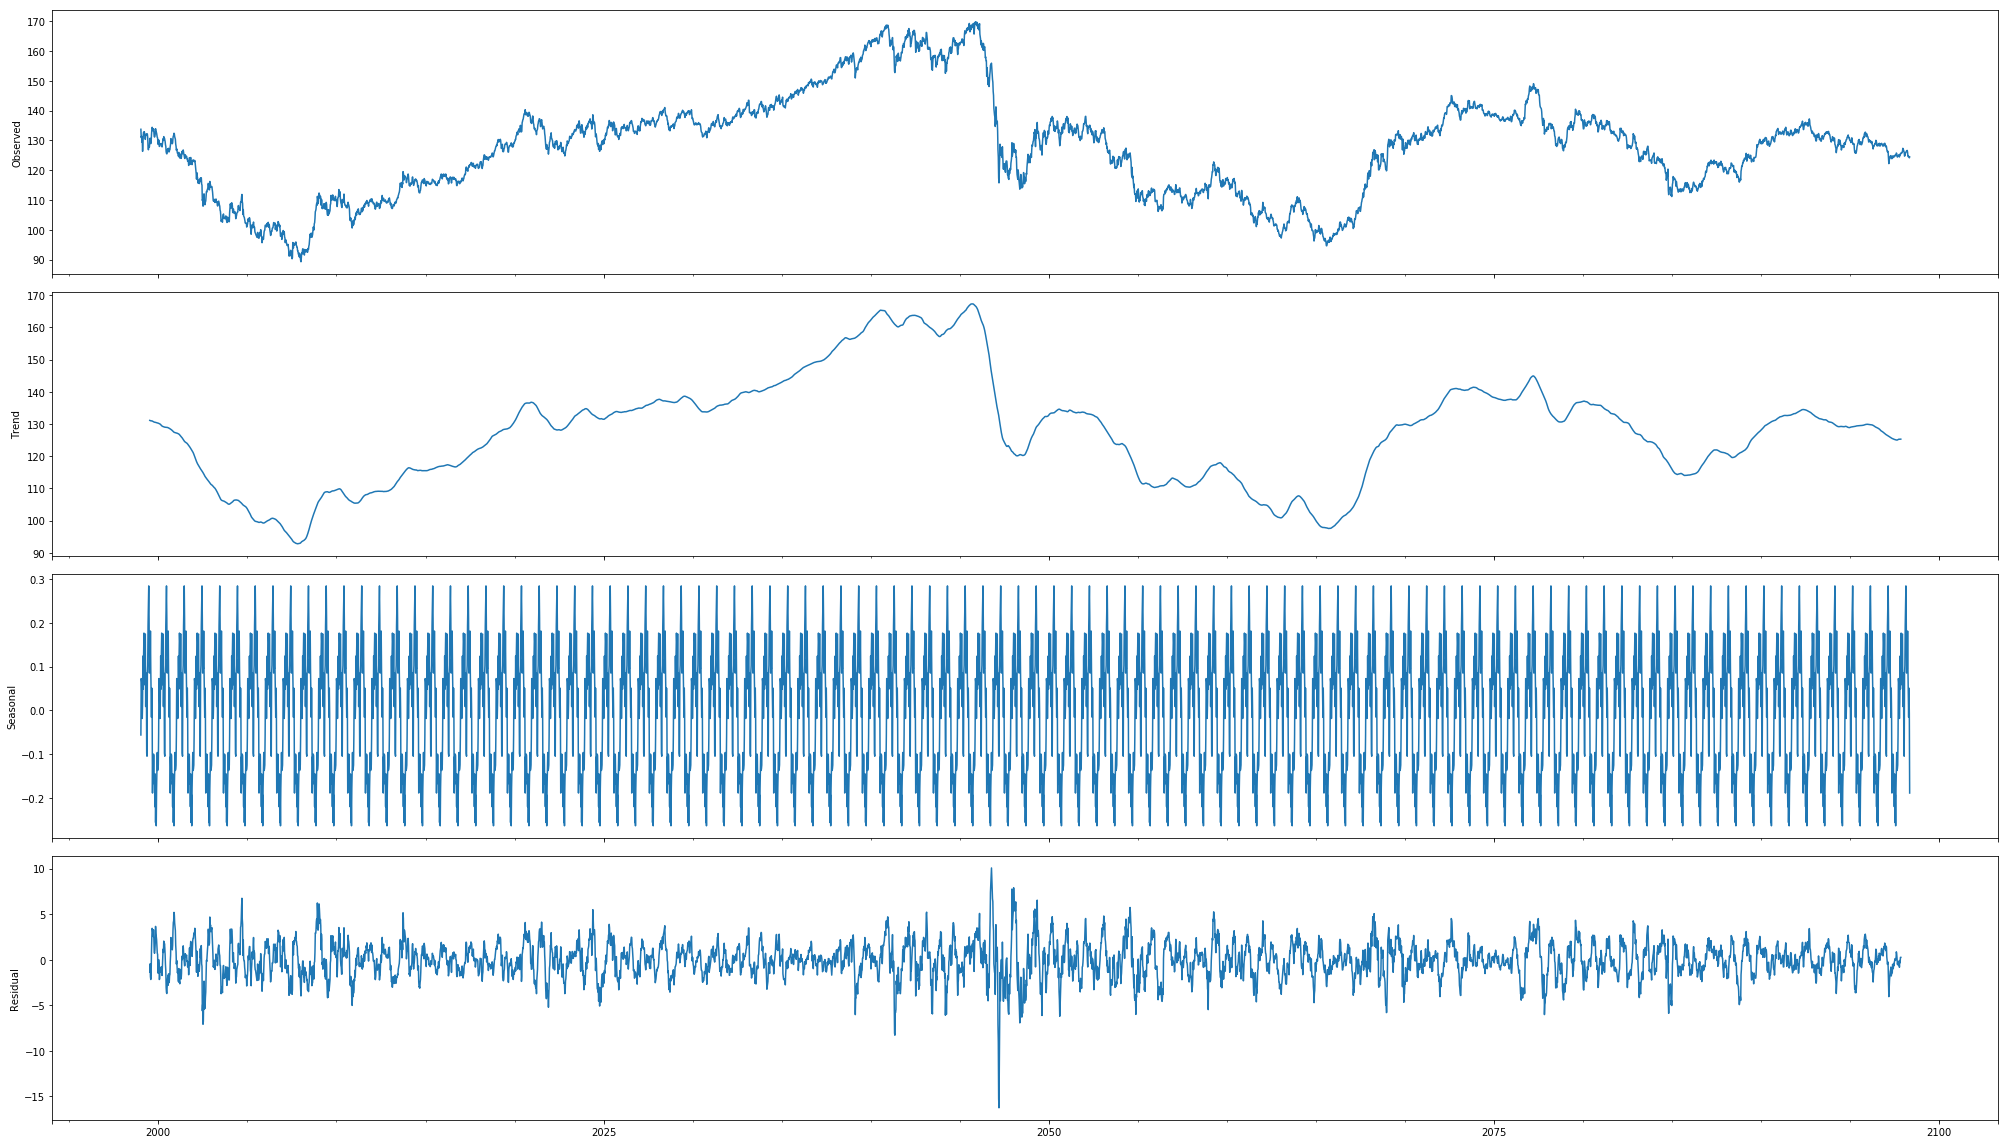

In [70]:
# Décomposition de la serie (Tendance, Saisonalité, Bruit)
rcParams['figure.figsize'] = 28, 16
decompo = sm.tsa.seasonal_decompose(df['rates'])
fig = decompo.plot()
plt.show()

freq = w pour week pour essayer de lisser la courbe et de faire ressortir une saisonnalité, ce qui est peu concluent.<br>
La tendance varie au fil du temps, pour la saisonnalité il est dificile de ressortir un mouvement réguilier.

On peut voir que la chute de 2012 entraine une grande dispersion du bruit. 
(Le bruit doit être uniformement distribué).<br>
Pour ces raisons je vais réduire l'historique afin d'avoir une courbe plus stable.

Pour cela j'extrait l'année dans une nouvelle colonne pour pouvoir l'utiliser comme filtre.

In [71]:
# Création d'une variable année

df['annee'] = pd.DatetimeIndex(df['date']).year 
df.head()

,date,rates,annee
1999-01-10,1999-01-04,133.73,1999
1999-01-17,1999-01-05,130.96,1999
1999-01-24,1999-01-06,131.42,1999
1999-01-31,1999-01-07,129.43,1999
1999-02-07,1999-01-08,130.09,1999


In [72]:
#extraction depuis 2013

li = [2013,2014,2015,2016,2017,2018,2019] #liste des années 

df13 = df.loc[df['annee'] ==  li[0]] #Création du df avec la première année

for i in range(0,len(li)):
    df13b = df.loc[df['annee'] ==  li[i]] # Extraction de chaque année
    df13 = df13.append(df13b) # Ajout de l'année extraire au df créé avec la premier année

df13 = df13.drop(['annee'], axis= 1) # Suppréssion de la variable année
df13.head()

,date,rates
2067-10-09,2013-01-02,115.38
2067-10-16,2013-01-03,113.93
2067-10-23,2013-01-04,114.96
2067-10-30,2013-01-07,114.48
2067-11-06,2013-01-08,114.56


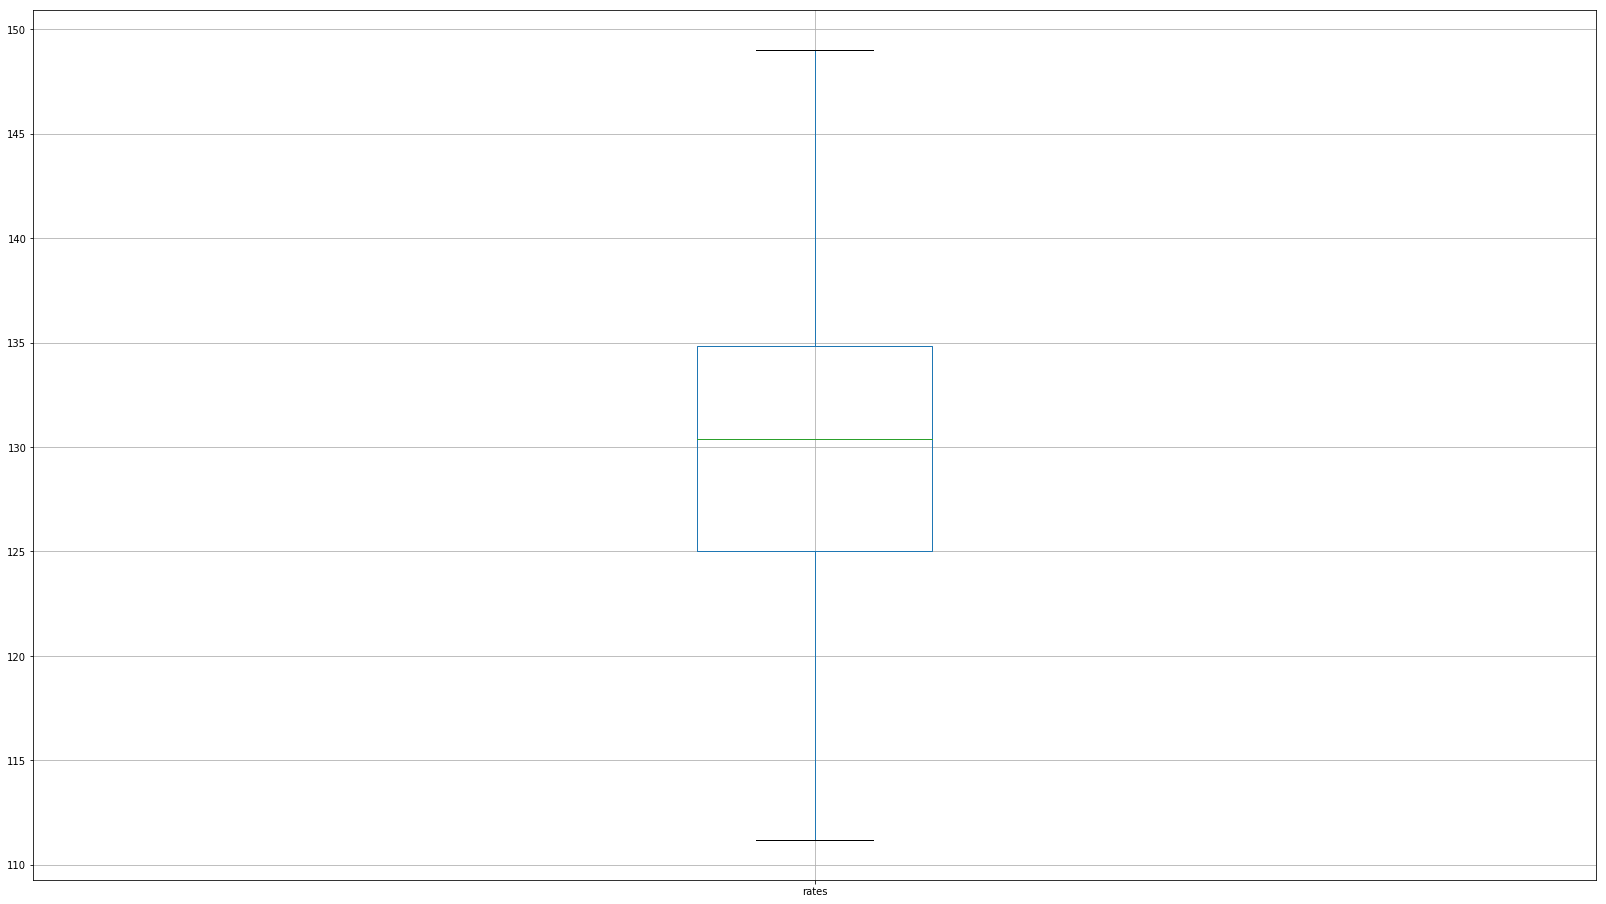

In [73]:
boxplot = df13.boxplot(column=['rates'])

Après découpage on remarque qu'il 'y a plus de valeurs extrèmes.

### Décomposition de la serie (Tendance, Saisonalité, Bruit) depuis 2013

In [74]:
df13.index= pd.DatetimeIndex(freq='w',start='2013-01-01',periods=len(df13))

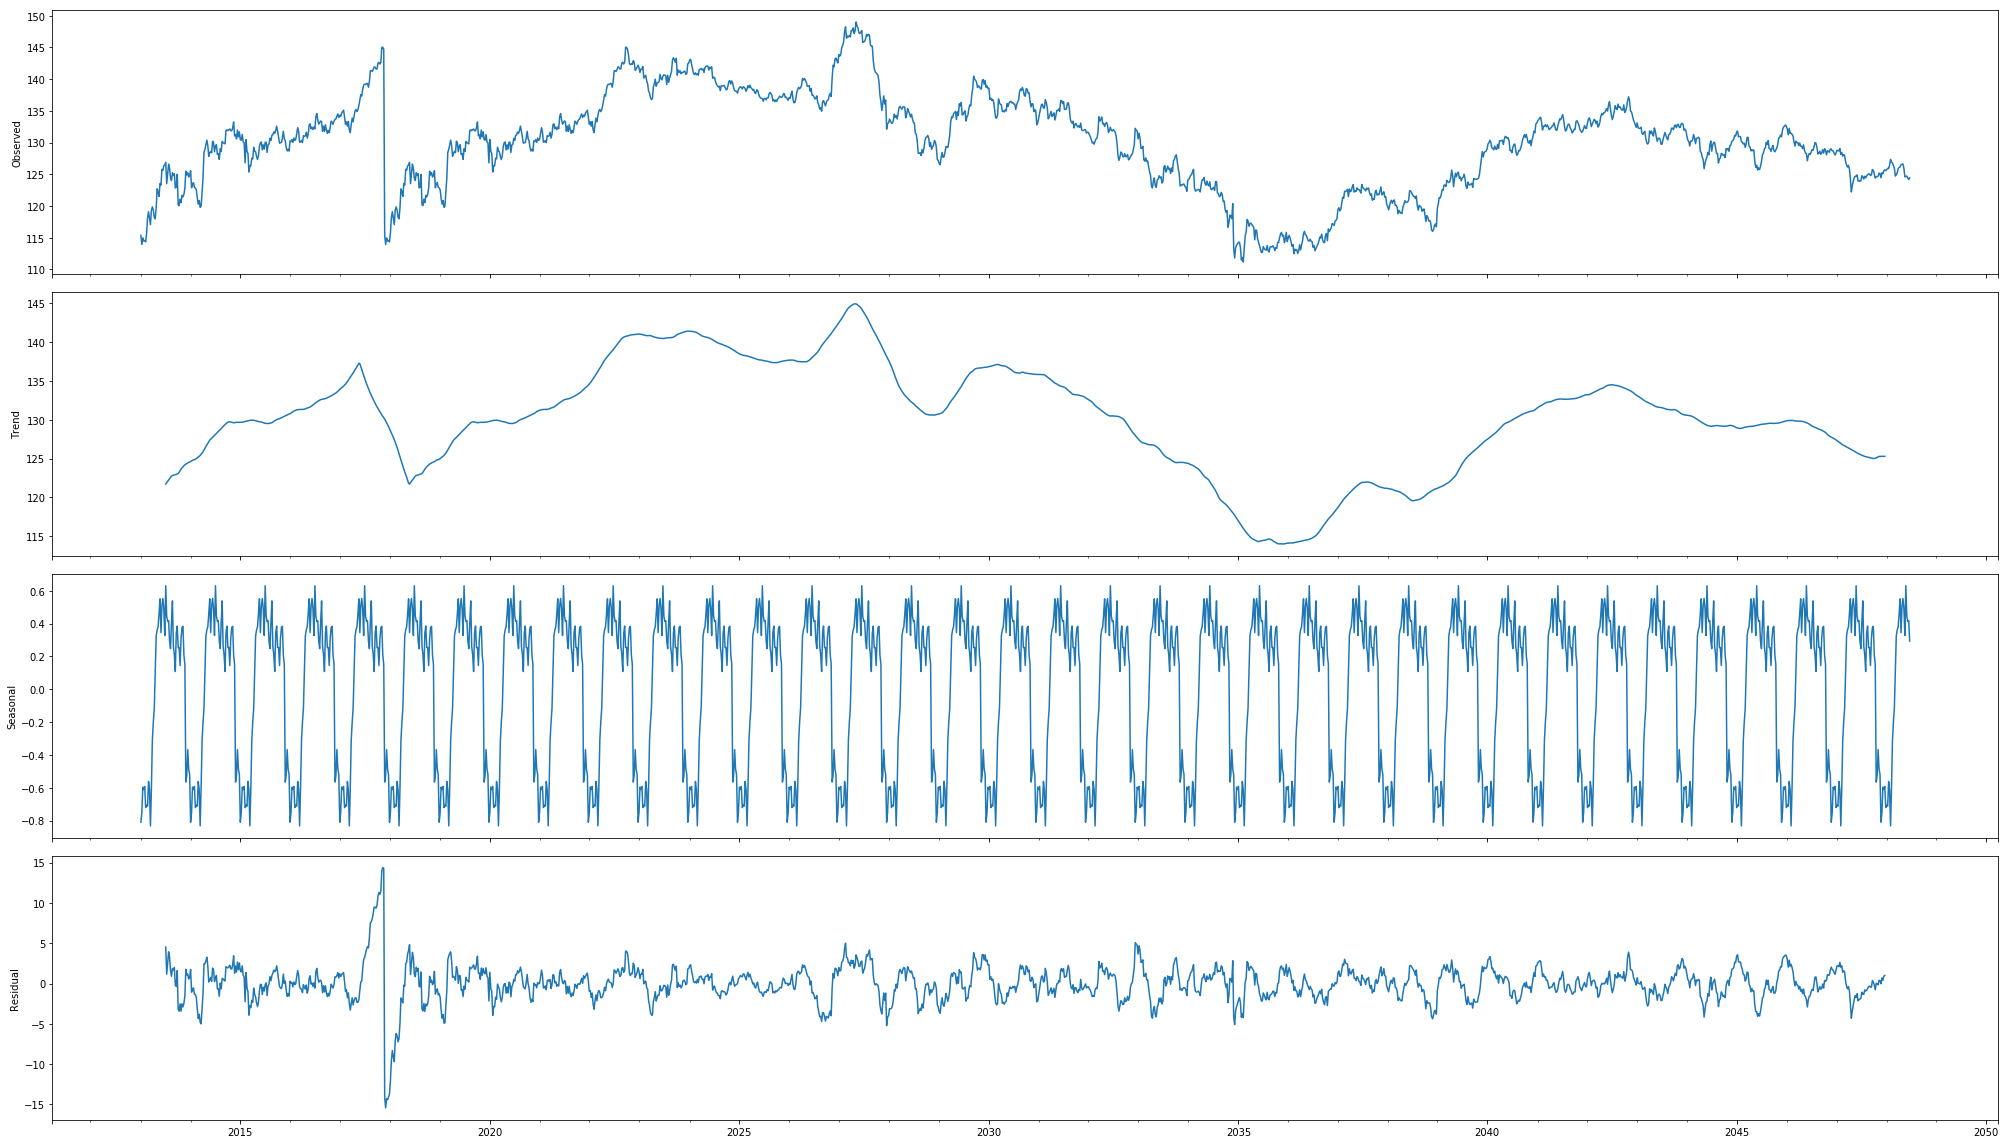

In [75]:
# Décomposition de la serie (Tendance, Saisonalité, Bruit)
rcParams['figure.figsize'] = 28, 16
decompo = sm.tsa.seasonal_decompose(df13['rates'], model='additive')
fig = decompo.plot()
plt.show()

Cependant on note encore une chute importante durant l'année 2013 qui fait fortement varier le bruit.<br>
De 2014 à aujourd'hui la serie semble plus stable, je vais donc essayer cette periode.

In [76]:
# Création df depuis 2014, Process identique

df['annee'] = pd.DatetimeIndex(df['date']).year 

lib = [2014,2015,2016,2017,2018,2019]
df14 = df.loc[df['annee'] ==  lib[0]]
for i in range(1,len(lib)):
    df14b = df.loc[df['annee'] ==  lib[i]]
    df14 = df14.append(df14b)

df14 = df14.drop(['annee'], axis= 1)

df14.head()

,date,rates
2072-08-28,2014-01-02,143.82
2072-09-04,2014-01-03,142.46
2072-09-11,2014-01-06,142.28
2072-09-18,2014-01-07,142.43
2072-09-25,2014-01-08,142.33


### Décomposition de la serie (Tendance, Saisonalité, Bruit) depuis 2014

In [77]:
df14.index= pd.DatetimeIndex(freq='w',start='2014-01-01',periods=len(df14))

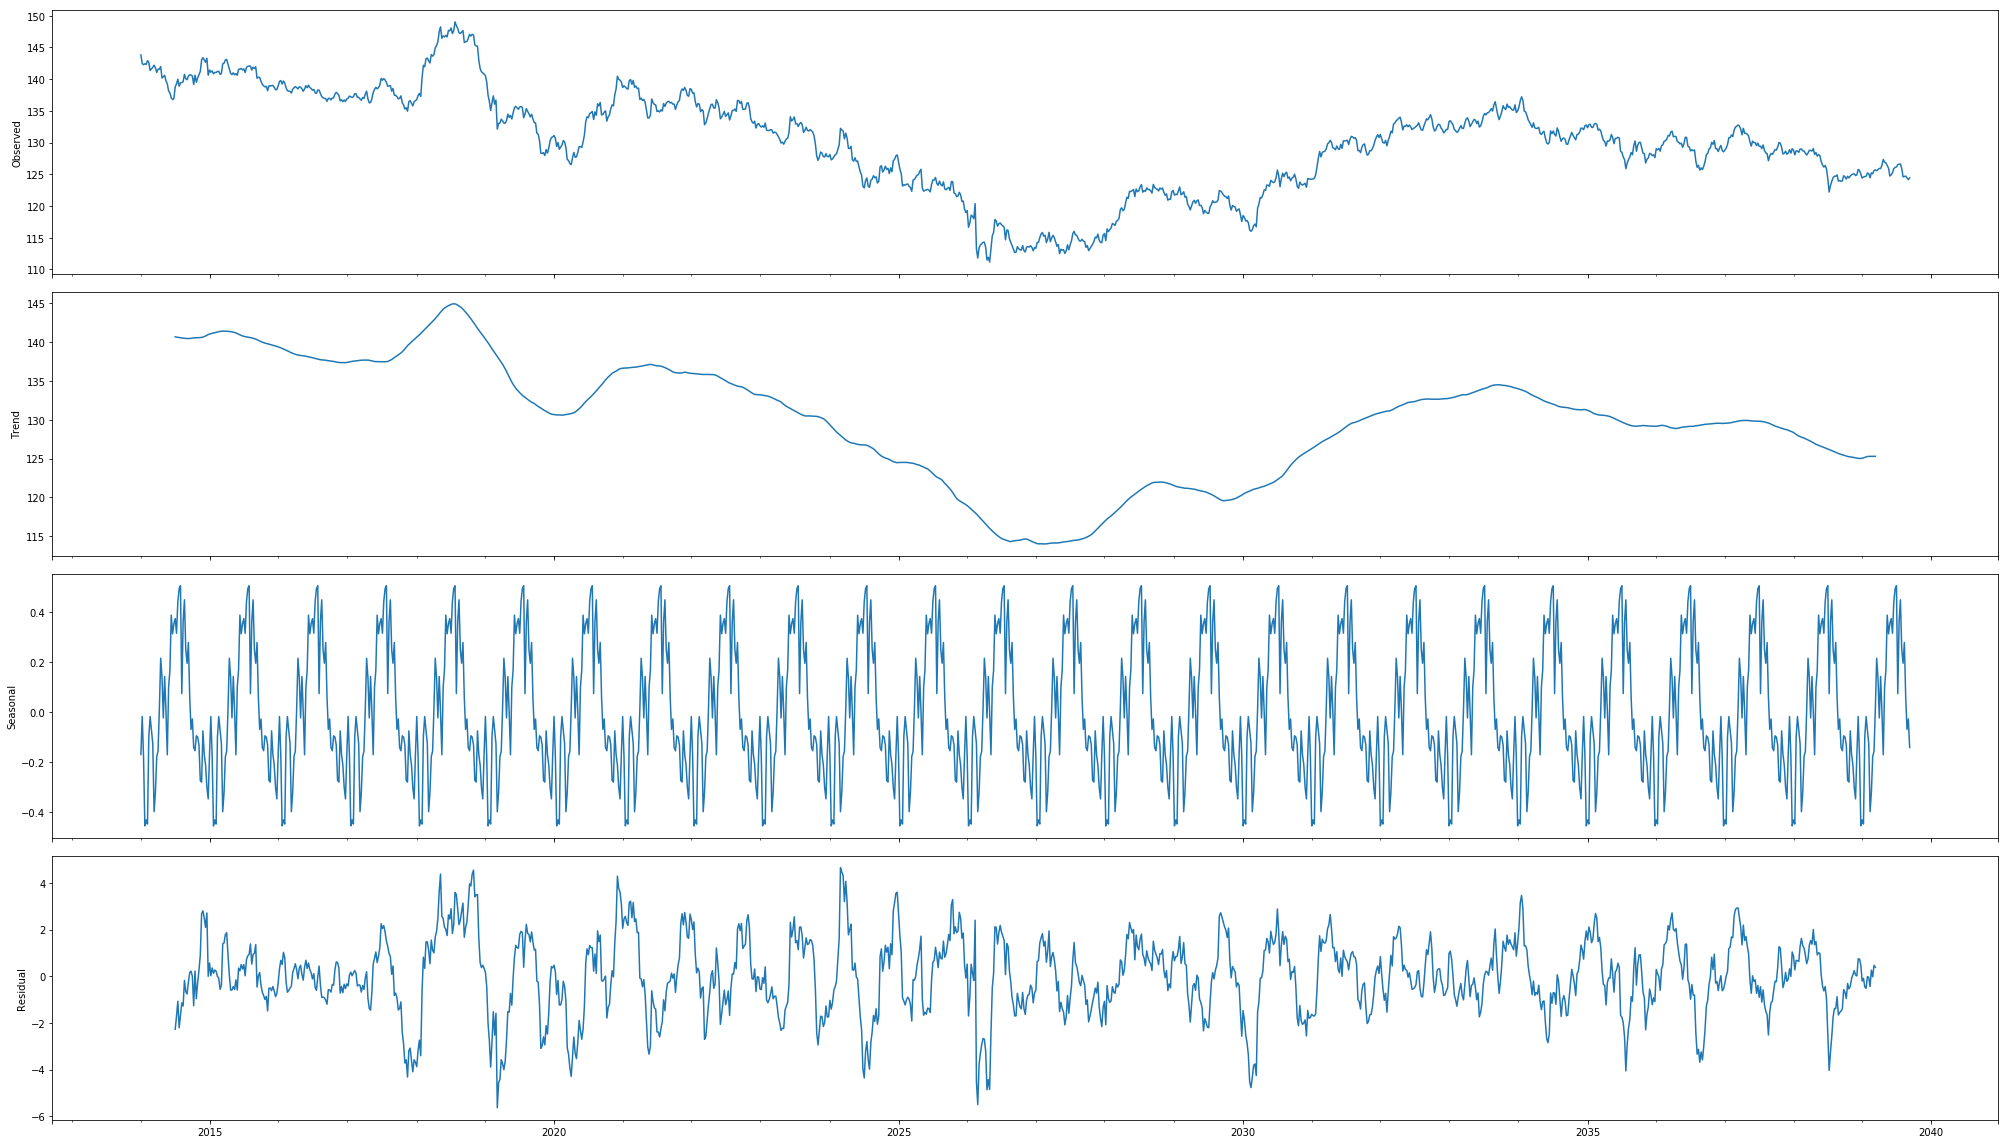

In [78]:
# Décomposition de la serie (Tendance, Saisonalité, Bruit)
rcParams['figure.figsize'] = 28, 16
decompo = sm.tsa.seasonal_decompose(df14['rates'])
fig = decompo.plot()
plt.show()

Ici nous avons des erreurs qui semblent distribuées plus aléatoirement autour de 0, sans pic qui écrase le reste de la série.

L'objectif étant de prédire à court terme je fais le choix de ne pas prendre l'entièreté de l'historique qui était trop chaotique. Je conserve donc cette série.

### Corrélogram

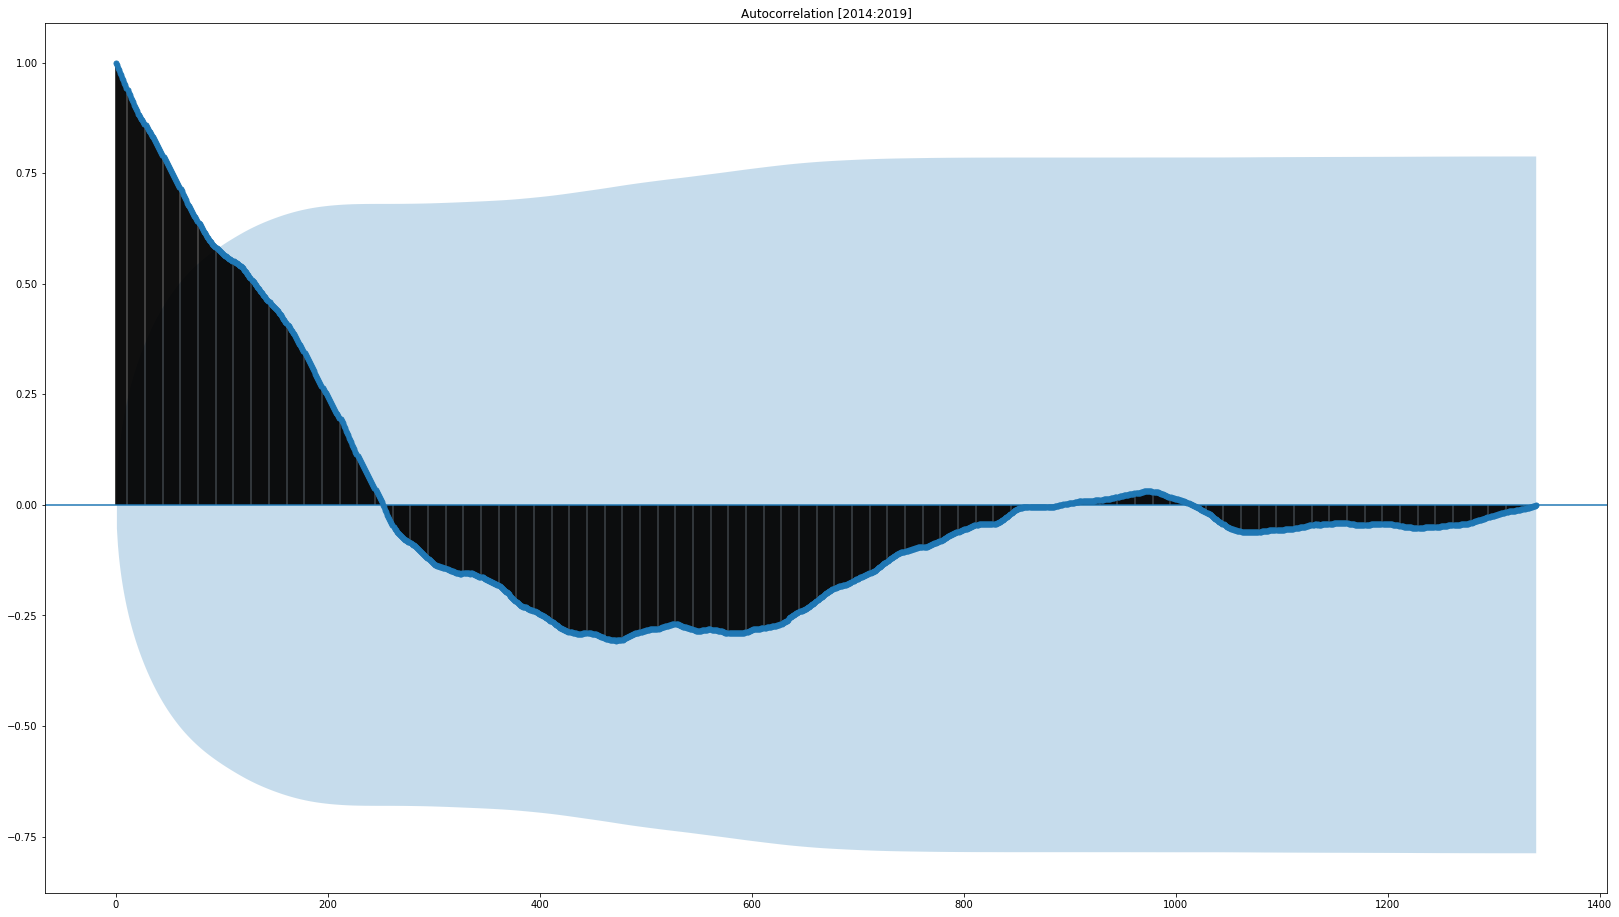

In [79]:
# Corrélogram
plot_acf(df14['rates'], title= 'Autocorrelation [2014:2019]' )
plt.show()

D'après ce corrélogramme on remarque que la série est très peu auto corrélée. L'ensemble des corrélations entre y et y (à un autre temps) n'est pas significative (ne sort pas de zone bleue).

Le seul moment où l'on trouve de la corrélation est lorsque on le compare avec un historique proche (debut du graph, hors de la zone bleue).

De ce fait on ne peut pas affirmer la présence de saisonnalité, une saisonnalité aurait été marquée par des pics hors de la zone bleue. C'est à dire quand y et y-t sont proches donc corrélés.

# 5 - Création de modèle

Avant la création du modèle il faut retirer le mois de mars 2019 pour pouvoir ensuite le prédire.
<br>Equivalaent aux données training (historique) et test (mars 2019).

In [92]:
# Création de var mois et année pour la selection
df14.sort_values(by=['date'], ascending=True)
df14['mois'] = pd.DatetimeIndex(df14['date']).month
df14['annee'] = pd.DatetimeIndex(df14['date']).year 

#création d'un df contenant uniquement mars 2019
dfm19 = df14.loc[(df14['annee'] == 2019) & (df14['mois'] == 3)]
dfm19.sort_values(by=['date'], ascending=True)
dfm19 = dfm19.drop(['annee','mois'], axis=1)


Après certains test il s'est avéré que mon ordinateurs ne supportait pas l'optimisation du modèle que je vais utiliser donc je reduit l'historique à 2 ans.

In [81]:
# Création df depuis fevrier 2017
df17 = df14
df17.sort_values(by=['date'], ascending=True)

df19 = df17
df19['annee'] = pd.DatetimeIndex(df19.index).year 

df19 = df19.drop(df19[df19.annee == 2017].index )
df19 = df19.drop(df19[df19.annee == 2018].index )
df19 = df19.drop(['annee'],axis=1)
df19.head()

#Création des variables mois et année
df17['annee'] = pd.DatetimeIndex(df17['date']).year 
df['annee'] = pd.DatetimeIndex(df['date']).year 


lib = [2017,2018,2019]
df17 = df.loc[df['annee'] ==  lib[0]]
for i in range(1,len(lib)):
    df17b = df.loc[df['annee'] ==  lib[i]]
    df17 = df17.append(df17b)

df17['mois'] = pd.DatetimeIndex(df17['date']).month

#séléction uniquement des 2 dernieres années
df17 = df17.drop(df17[df17.annee == 2017].index & df17[df17.mois== 1].index )
df17 = df17.drop(df17[df17.annee == 2017].index & df17[df17.mois== 2].index )
df17 = df17.drop(df17[df17.annee == 2019].index & df17[df17.mois== 3].index )

#Suppression de colonnes inutiles à présent
df17 = df17.drop(['annee' , 'mois'], axis= 1)

# Passage de la date en index
df17.set_index(['date'], inplace=True)
df17.head()

df17.head()

,rates
date,
2017-03-01,119.84
2017-03-02,120.24
2017-03-03,120.83
2017-03-06,120.55
2017-03-07,120.61


On peut rapidement décomposer la série depuis 2017.

In [210]:
df17.index= pd.DatetimeIndex(freq='w',start='2013-01-01',periods=len(df17))

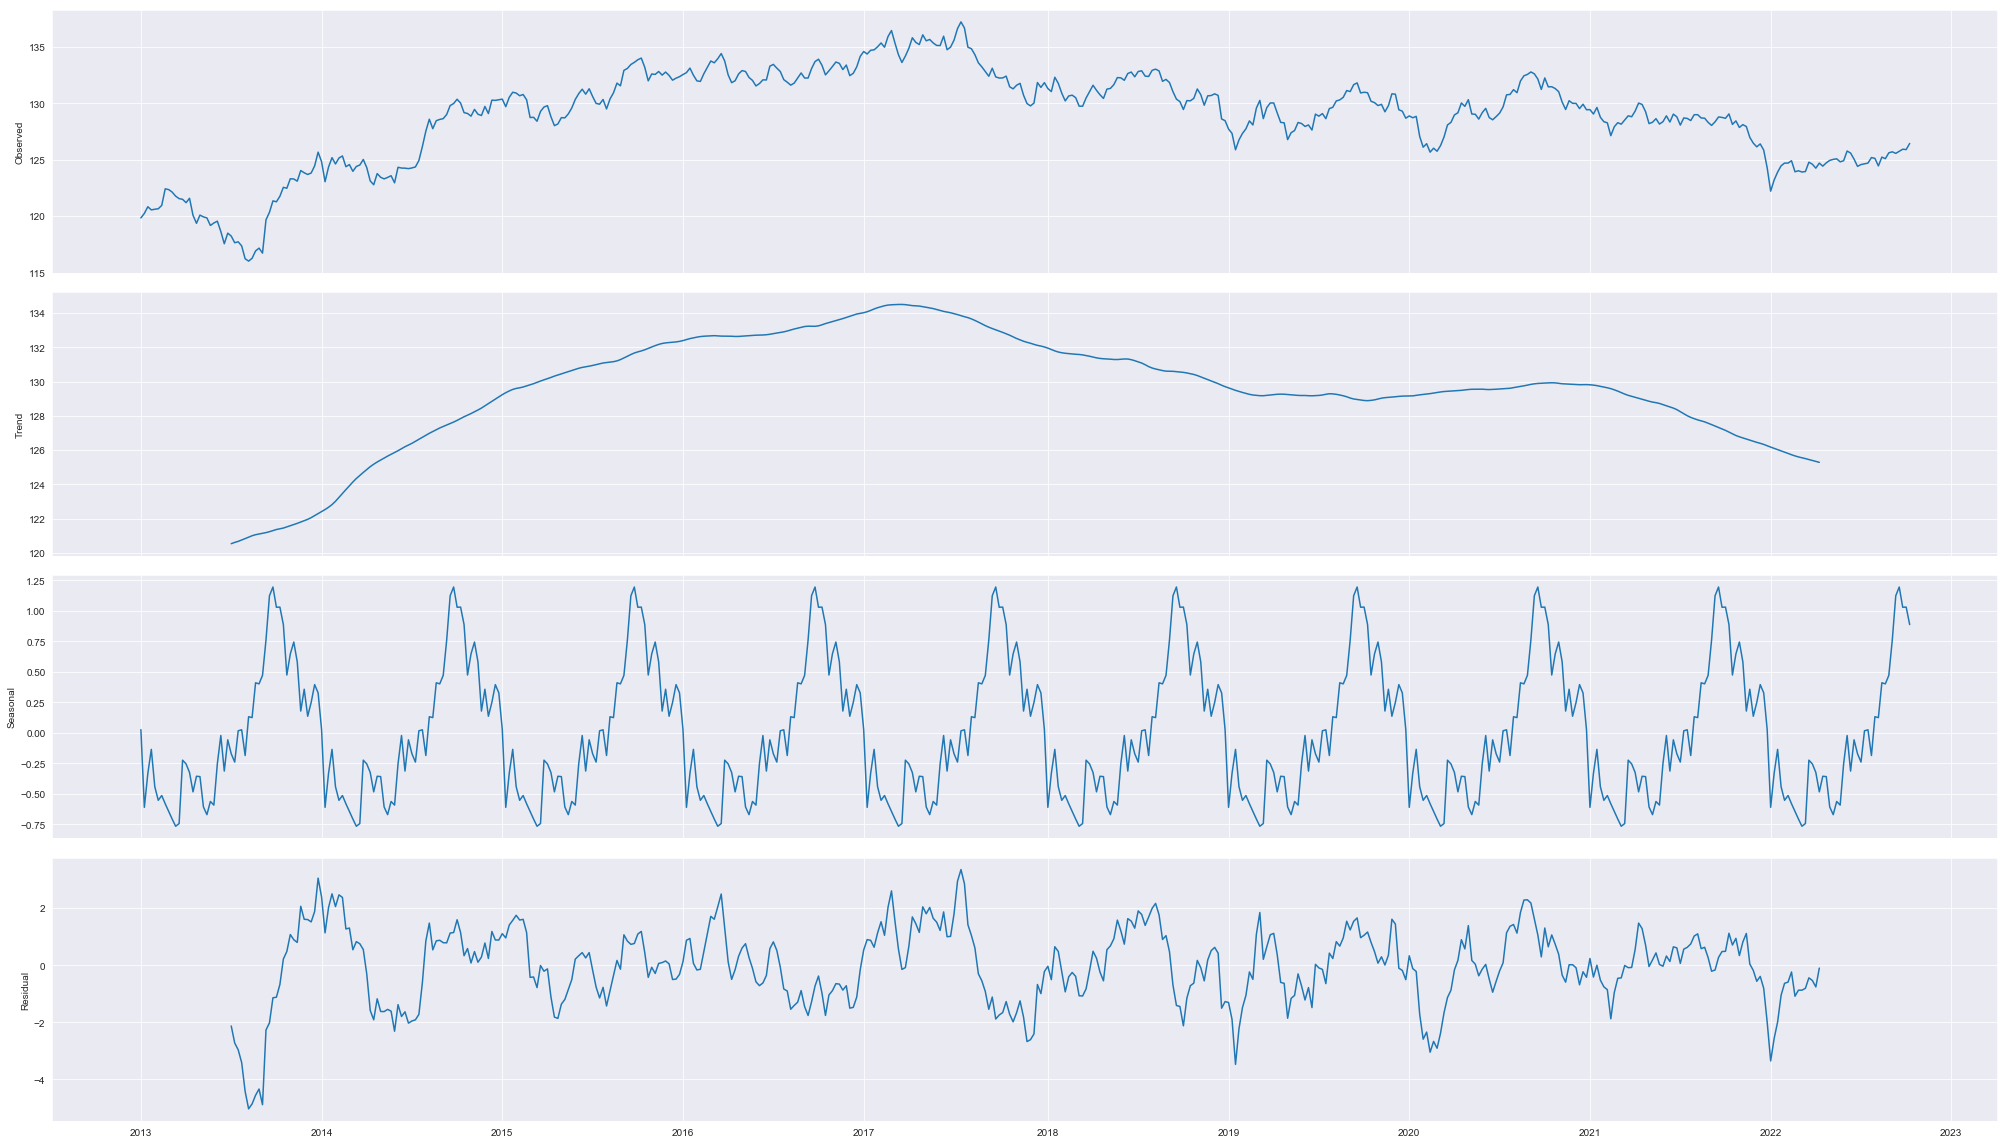

In [211]:
#Decomposition de la serie (Tendance,Saisonalité,Bruit)
rcParams['figure.figsize'] = 28, 16
decompo = sm.tsa.seasonal_decompose(df17['rates'])
fig = decompo.plot()
plt.show()

On remarque une tendance très lisse et sans majeur fluctuatuion, ce qui jouera sur la prédiction.

## Modèle ARIMA

Je vais utiliser le modèle ARIMA. Ce modèle prend en compte l'historique de la série (partie AR, auto régressive) mais aussi les moyennes mobiles (MA) pour prédire.

Le modèle ARIMA est composé de 3 paramètres, p, d et q.
<br> p est la partie auto régressive qui va prendre en compte l'historique de la série.
<br>d est la paramètre de saisonnalité permettant d'avoir une série stationnaire.
<br>q est la partie des moyennes mobiles qui va utiliser les erreurs anterieures pour prédire l'erreur du modèle.

In [33]:
#choix de la fréquence 
freq = 22

La periode est souvent définie par la saisonnalite, si un mouvement revient chaque année avec des données mensuelle alors la periode ser ade 12.
Si un mouvement reveint chaque semaine avec des données journalières la période sera de 7...

Ici il est difficile d'extraire une saisonnalité, cependant notre objectif est de prédire un mois, dans un mois il y a en moyenne 22 jours ouvrés je choisis donc cette periode.

In [34]:
# Define the d and q parameters to take any value between 0 and 1
# Paramètres q et d peuvent prendre 0 ou 1
q = d = range(0, 2)

# p peut prendre 0,1,2 ou 3.
p = range(0, 4)

#Génération des combinaisons possibles entre les 3 paramètres
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], freq) for x in list(itertools.product(p, d, q))]

print('Examples de combinaison entre les paramètres')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples de combinaison entre les paramètres
SARIMAX: (0, 0, 1) x (0, 0, 1, 22)
SARIMAX: (0, 0, 1) x (0, 1, 0, 22)
SARIMAX: (0, 1, 0) x (0, 1, 1, 22)
SARIMAX: (0, 1, 0) x (1, 0, 0, 22)


On va donc effectuer le grid search, nous choisirons le meilleur modèle selon le critère de l'AIC qui sera calculé pour chaque modèle.

In [214]:
warnings.filterwarnings("ignore") # supression des warnigs

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df17['rates'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 22) - AIC:6393.240868649102
SARIMAX(0, 0, 0)x(0, 0, 1, 22) - AIC:5534.00895130568
SARIMAX(0, 0, 0)x(0, 1, 0, 22) - AIC:2413.721272414591
SARIMAX(0, 0, 0)x(0, 1, 1, 22) - AIC:2262.3003363371217
SARIMAX(0, 0, 0)x(1, 0, 0, 22) - AIC:2418.1287201912282
SARIMAX(0, 0, 0)x(1, 0, 1, 22) - AIC:2384.06384149278
SARIMAX(0, 0, 0)x(1, 1, 0, 22) - AIC:2250.3045893229773
SARIMAX(0, 0, 0)x(1, 1, 1, 22) - AIC:2203.6710416938704
SARIMAX(0, 0, 0)x(2, 0, 0, 22) - AIC:2246.119160739211
SARIMAX(0, 0, 0)x(2, 0, 1, 22) - AIC:2205.6251852438727
SARIMAX(0, 0, 0)x(2, 1, 0, 22) - AIC:2046.135850638652
SARIMAX(0, 0, 0)x(2, 1, 1, 22) - AIC:1975.3468523228917
SARIMAX(0, 0, 0)x(3, 0, 0, 22) - AIC:2048.0250593070223
SARIMAX(0, 0, 0)x(3, 0, 1, 22) - AIC:1879.6151274594026
SARIMAX(0, 0, 0)x(3, 1, 0, 22) - AIC:1915.5913906990331
SARIMAX(0, 0, 0)x(3, 1, 1, 22) - AIC:1884.6763462355038
SARIMAX(0, 0, 1)x(0, 0, 0, 22) - AIC:5686.411912728843
SARIMAX(0, 0, 1)x(0, 0, 1, 22) - AIC:4858.310922342243
SA

SARIMAX(2, 0, 1)x(1, 0, 1, 22) - AIC:931.7575612698245
SARIMAX(2, 0, 1)x(1, 1, 0, 22) - AIC:1066.2296067430386
SARIMAX(2, 0, 1)x(1, 1, 1, 22) - AIC:956.6733361758766
SARIMAX(2, 0, 1)x(2, 0, 0, 22) - AIC:874.8715510192853
SARIMAX(2, 0, 1)x(2, 0, 1, 22) - AIC:877.4239821859701
SARIMAX(2, 0, 1)x(2, 1, 0, 22) - AIC:950.3451962636593
SARIMAX(2, 0, 1)x(2, 1, 1, 22) - AIC:886.5144579311676
SARIMAX(2, 0, 1)x(3, 0, 0, 22) - AIC:820.8167575498944
SARIMAX(2, 0, 1)x(3, 0, 1, 22) - AIC:839.3797288341641
SARIMAX(2, 0, 1)x(3, 1, 0, 22) - AIC:871.525715876242
SARIMAX(2, 0, 1)x(3, 1, 1, 22) - AIC:823.2659249548767
SARIMAX(2, 1, 0)x(0, 0, 0, 22) - AIC:969.9524706922796
SARIMAX(2, 1, 0)x(0, 0, 1, 22) - AIC:933.1259629742683
SARIMAX(2, 1, 0)x(0, 1, 0, 22) - AIC:1290.5638974780204
SARIMAX(2, 1, 0)x(0, 1, 1, 22) - AIC:936.112821203669
SARIMAX(2, 1, 0)x(1, 0, 0, 22) - AIC:929.291940222646
SARIMAX(2, 1, 0)x(1, 0, 1, 22) - AIC:927.1867123579373
SARIMAX(2, 1, 0)x(1, 1, 0, 22) - AIC:1070.21024297769
SARIMAX(2, 1

## Fit Modèle

Le modèle que l'on conserve est le suivant : SARIMAX(2, 1, 1)x(3, 0, 1, 22) - AIC:812.7385849105019

In [82]:
warnings.filterwarnings("ignore") # supression des warnigs
mod = sm.tsa.statespace.SARIMAX(df17['rates'],
                                order=(2, 1, 1),
                                seasonal_order=(3, 0, 1, 22),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

## Etude des résidus du modèle

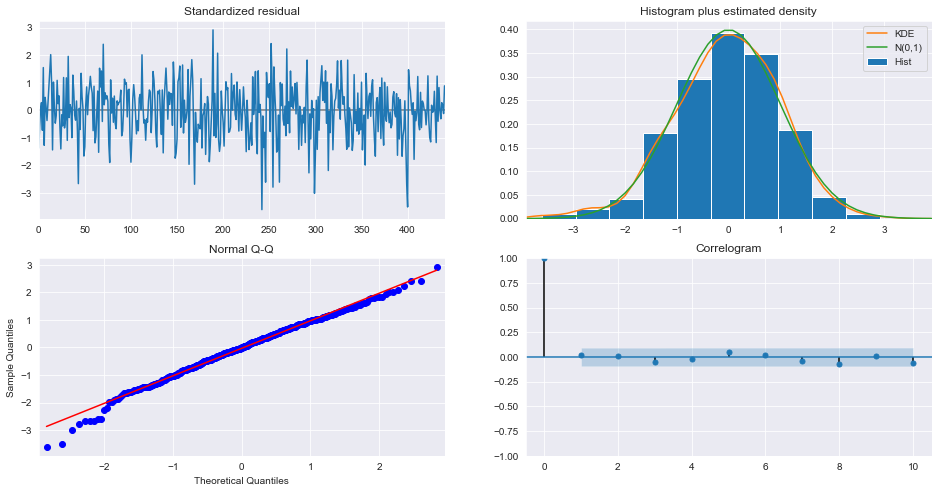

In [35]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Sur le premier graphique (haut, gauche) on remarque que les points sont globalement distribués autour de 0 avec quelques exceptions.
<br>Ceci est confirmé par le second graphique (haut, droite) ou observe que les résidus suivent le comportement d'une loi normale centré reduite, ce qui est bon signe.
<br>Il n'y a pas de corrélation au sein des résidus, ni de saisonnalité comme le montre le corrélogramme.

# 6 - Prédiction

Création d'un dataframe de 2019 pour pouvoir mieux visualiser la courbe uniquement sur cette période.

In [83]:
df19 = df17
df19['annee'] = pd.DatetimeIndex(df19.index).year 

df19 = df19.drop(df19[df19.annee == 2017].index )
df19 = df19.drop(df19[df19.annee == 2018].index )
df19 = df19.drop(['annee'],axis=1)
df19.head()

,rates
date,
2019-01-02,124.28
2019-01-03,122.21
2019-01-04,123.20
2019-01-07,123.90
2019-01-08,124.46


### Réalisation de la prédiction :

In [84]:

pred = results.get_forecast(509)
pred_ci = pred.conf_int()

Une fois les valeurs prédites on peut les comparer aux valeurs observées pour mars.

In [90]:
# Stockage des prédictions de mars 2019
dfpm19=0
dfpm19 =dfm19  # Copie de df
for i in range(1,22):
    dfpm19['rates'].iloc[i-1] =pred.predicted_mean[509+i]  # Remplacement de valeurs par les prédictions dans la copie



In [93]:
#affichage du réel et de l'estimé

print( 'Données rééls Mars 19 :', dfm19)
print( 'Données prédites Mars 19 :', dfpm19 )

Données rééls Mars 19 :                  date   rates
2039-04-24 2019-03-01  127.35
2039-05-01 2019-03-04  126.91
2039-05-08 2019-03-05  126.80
2039-05-15 2019-03-06  126.40
2039-05-22 2019-03-07  125.97
2039-05-29 2019-03-08  124.72
2039-06-05 2019-03-11  124.91
2039-06-12 2019-03-12  125.27
2039-06-19 2019-03-13  125.89
2039-06-26 2019-03-14  126.09
2039-07-03 2019-03-15  126.16
2039-07-10 2019-03-18  126.54
2039-07-17 2019-03-19  126.59
2039-07-24 2019-03-20  126.63
2039-07-31 2019-03-21  125.92
2039-08-07 2019-03-22  124.60
2039-08-14 2019-03-25  124.65
2039-08-21 2019-03-26  124.72
2039-08-28 2019-03-27  124.42
2039-09-04 2019-03-28  124.16
2039-09-11 2019-03-29  124.45
Données prédites Mars 19 :                  date       rates
2039-04-24 2019-03-01  126.495177
2039-05-01 2019-03-04  126.534728
2039-05-08 2019-03-05  126.559811
2039-05-15 2019-03-06  126.604875
2039-05-22 2019-03-07  126.609442
2039-05-29 2019-03-08  126.607848
2039-06-05 2019-03-11  126.619143
2039-06-12 2019-0

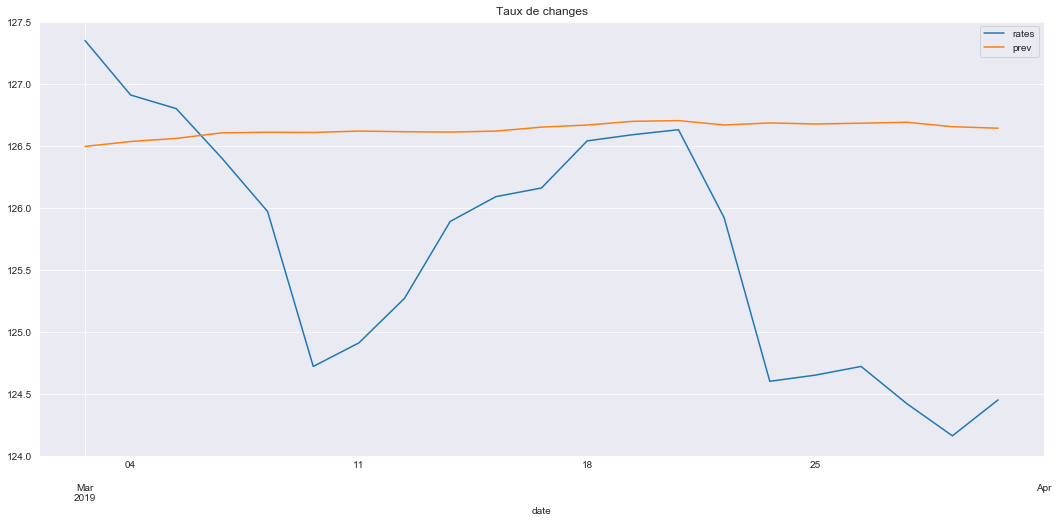

In [176]:
#Plot de la courbe réel et estimé
dfprev = dfm19.copy()
dfprev['prev'] = dfpm19['rates']

dfprev.plot(x ='date',y = ['rates','prev'], figsize=(18,8), title = "Taux de changes")


Comme on peut le voir les prédictions du modèle sont très stables, elles fluctuent au sein de 126.
Les données observées elles fluctuent entre 124 et 127, ce qui est très proche, il et dificile de créer un modèle capable de prédire aussi préciement.

In [95]:
#Calcul de l'équarrt entre le réél et la prévision du modèle 
scr = 0
rmse = 0
for i in range(0,21):
 
    ecart_ind = ((dfpm19['rates'].iloc[i] - dfm19['rates'].iloc[i])**2)
    scr = scr + ecart_ind
rmse = sqrt(scr/21)
print( 'SCR : ', scr )
print('RMSE :' ,rmse)

SCR :  39.78849148699605
RMSE : 1.3764774138391576


## Conclusion sur le modèle

Il me semble dificile de prédire correctement la série. En effet, le modele prédit une stabilité avec un très faible fluctuation.  (prévision de 126 avec des décimales variantes).<br>
Le modèle est stable et proche des valeurs réelles du fait des moyennes mobiles, mais il ne permet pas de prédire réellement la série.

Cependant les données à prédire fluctuent très peu (entre 124 et 127), sans saisonnalité il est dur de pouvoir prédire à quel moment la serie croit ou décroit.

On pourrait toute fois ajouter un bruit plus important au modèle, ce qui augmenterait sa variation. Mais la prédiction deviendrait alors aléatoire.

Il existe des modèle "boursier" qui seraient plus adaptés, comme le modèle ARCH et ses déclinaisons.